The goal are:
- to check that step 2 works correctly;
- to choose if we should use the inverse of the sum or the sum of the inverses in the linear sum assignment of step 2;
- to check that steps 3 and 4 work correctly.

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# sample data

In [2]:
# parameters
m = 10
p = 5
noise = 0.01
option = 2
random_state = 47
rng = np.random.RandomState(random_state)

In [3]:
def sample_data(m, p, noise, rng):
    # causal effect matrices
    B = rng.normal(size=(m, p, p))
    for i in range(m):
        B[i][np.triu_indices(p, k=0)] = 0  # set the strictly upper triangular part to 0

    # causal order
    P = np.eye(p)
    rng.shuffle(P)

    # ICA sign-permutation matrix
    Q = np.eye(p)
    signs = rng.choice([-1, 1], size=p)
    Q *= signs
    rng.shuffle(Q)

    # unmixing matrices
    W = np.array([P.T @ (np.eye(p) - Bi) @ P for Bi in B])

    # unmixing matrices obtained by ShICA
    N = noise * rng.normal(size=(m, p, p))
    W_ica = np.array([Q @ Wi + Ni for Wi, Ni in zip(W, N)])
    
    return W_ica, B, P, Q

W_ica, B, P, Q = sample_data(m, p, noise, rng)

# retrieve order Q

In [4]:
# linear sum assignment
if option == 1:
    W_inv = np.sum([1 / np.abs(Wi.T) for Wi in W_ica], axis=0)  # first option
elif option == 2:
    W_inv = 1 / np.sum([np.abs(Wi.T) for Wi in W_ica], axis=0)  # second option
_, index = linear_sum_assignment(W_inv)
W_estimates = np.array([Wi[index] for Wi in W_ica])

In [5]:
# true VS estimated order
true_index = np.argmax(np.abs(Q), axis=0)
print(f"True ICA-order Q : {true_index}")
print(f"Estimated ICA-order Q : {index}")

if (true_index == index).all():
    print("The order is retrieved!")
else:
    print("The order is not retrieved.")

True ICA-order Q : [3 0 2 4 1]
Estimated ICA-order Q : [3 0 2 4 1]
The order is retrieved!


In [6]:
# average absolute difference between diagonal elements and +-1
error = np.mean([np.abs(np.abs(np.diag(Wi)) - 1) for Wi in W_estimates])
error

0.008079345734096624

# plot re-ordered matrices QWi

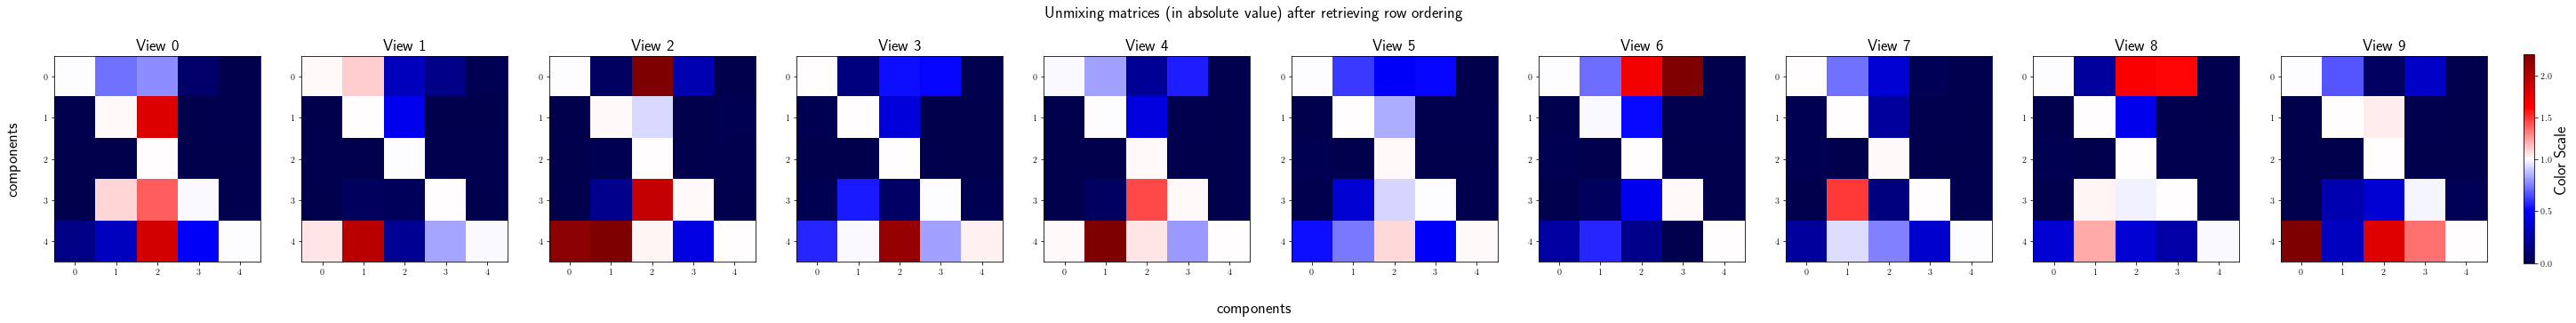

In [7]:
# plot re-permuted matrices
def heat_maps_W(W_estimates, absolute_value=True):
    m, p, _ = W_estimates.shape
    fontsize = 18
    fig, axes = plt.subplots(1, m, figsize=(m*5, 5))
    if absolute_value:
        vmin = 0
    else:
        vmin = np.min(W_estimates)
    norm = TwoSlopeNorm(vmin=vmin, vmax=np.max(W_estimates), vcenter=1)
    for i, ax in enumerate(axes.flat):
        if absolute_value:
            Wi = np.abs(W_estimates[i])
        else:
            Wi = W_estimates[i]
        im = ax.imshow(Wi, norm=norm, cmap="seismic")
        ax.set_title(f"View {i}", fontsize=fontsize)
    cbar = fig.colorbar(im, ax=axes, fraction=0.0042, pad=0.015)
    cbar.set_label('Color Scale', fontsize=fontsize)
    if absolute_value:
        title_sup = "(in absolute value)"
    else:
        title_sup = ""
    fig.suptitle(f"Unmixing matrices {title_sup} after retrieving row ordering", fontsize=fontsize)
    fig.supxlabel("components", fontsize=fontsize)
    fig.supylabel("components", fontsize=fontsize, x=0.11)
    plt.show()

heat_maps_W(W_estimates)

We retrieve matrix Q.

# re-scale matrices

In [8]:
# divide each unmixing matrix by its diagonal elements
D = np.array([np.diag(Wi) for Wi in W_estimates])[:, :, np.newaxis]  # shape (m, p, 1)
DQW = W_estimates / D

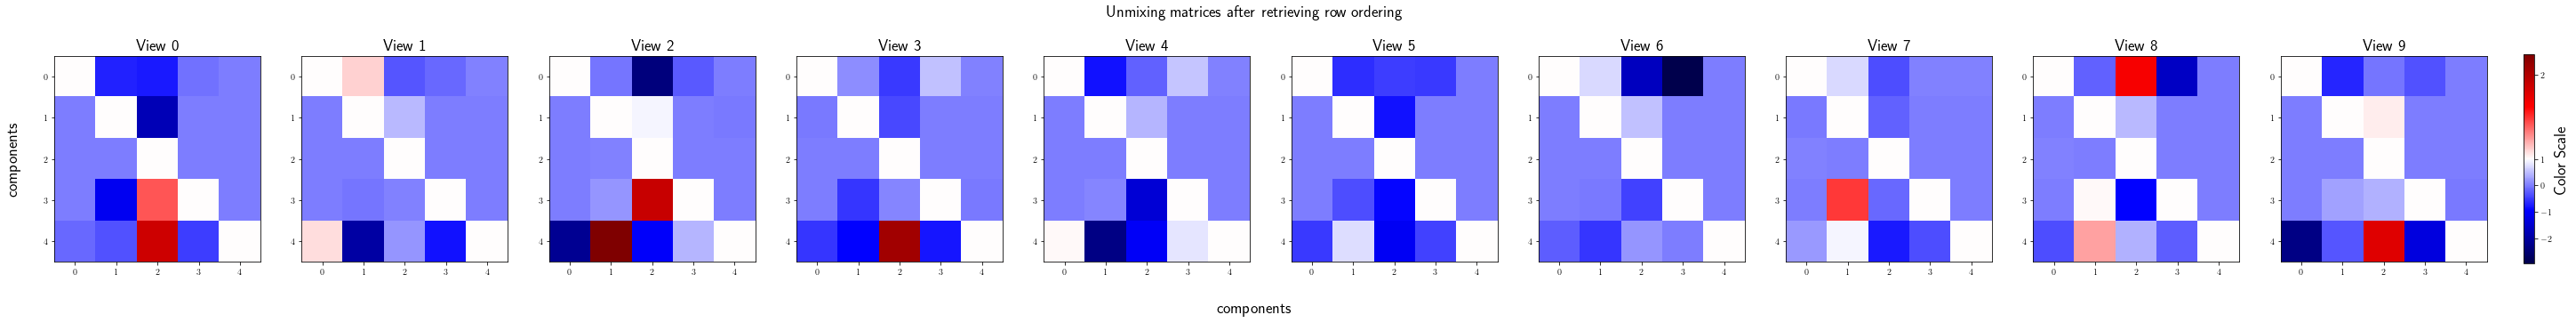

In [9]:
# plot re-scaled matrices
heat_maps_W(DQW, absolute_value=False)

In [10]:
# sanity check
diags = np.array([np.diag(Wi) for Wi in DQW])
assert (diags == 1).all()

# compute causal effects

In [11]:
# causal effects matrices
B = np.array([np.eye(p)] * m) - DQW
B.shape

(10, 5, 5)

# compare the 2 options for W_inv

In [12]:
# varying parameters
noise_list = np.logspace(-2, 1, 19)
nb_seeds = 100
random_state_list = np.arange(nb_seeds)

In [13]:
# main function
def run_experiment(noise, random_state, m, p, option=1):
    # sample data
    W_ica, _, _, Q = sample_data(m, p, noise, np.random.RandomState(random_state))
    true_index = np.argmax(np.abs(Q), axis=0)
    # linear sum assignment
    if option == 1:
        W_inv = np.sum([1 / np.abs(Wi.T) for Wi in W_ica], axis=0)  # first option
    elif option == 2:
        W_inv = 1 / np.sum([np.abs(Wi.T) for Wi in W_ica], axis=0)  # second option
    _, index = linear_sum_assignment(W_inv)
    # error
    return 1 - (index == true_index).all()

In [14]:
# option 1
results_1 = np.array([
    run_experiment(noise_, random_state_, m, p, option=1)
    for noise_, random_state_
    in product(noise_list, random_state_list)])
results_1 = results_1.reshape(len(noise_list), len(random_state_list))
error_rate_1 = np.mean(results_1, axis=1)

# option 2
results_2 = np.array([
    run_experiment(noise_, random_state_, m, p, option=2)
    for noise_, random_state_
    in product(noise_list, random_state_list)])
results_2 = results_2.reshape(len(noise_list), len(random_state_list))
error_rate_2 = np.mean(results_2, axis=1)

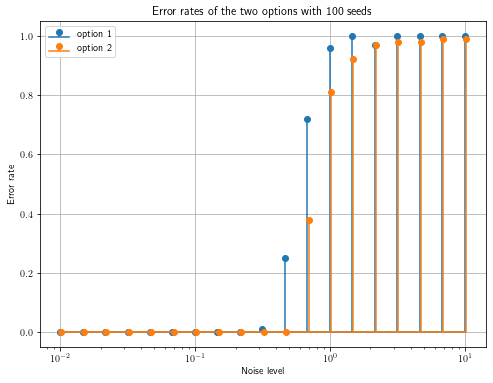

In [15]:
# colors
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# plot rates
plt.figure(figsize=(8, 6))

stem1 = plt.stem(noise_list, error_rate_1, label='option 1')
plt.setp(stem1.markerline, color=colors[0])  # Set marker color
plt.setp(stem1.stemlines, color=colors[0])   # Set stem line color
plt.setp(stem1.baseline, color=colors[0])    # Set baseline color
epsilon = 2 * 1e-2 * noise_list
stem2 = plt.stem(noise_list + epsilon, error_rate_2, label='option 2')
plt.setp(stem2.markerline, color=colors[1])  # Set marker color
plt.setp(stem2.stemlines, color=colors[1])   # Set stem line color
plt.setp(stem2.baseline, color=colors[1])    # Set baseline color

plt.xscale("log")
plt.legend()
plt.title(f"Error rates of the two options with {nb_seeds} seeds")
plt.xlabel("Noise level")
plt.ylabel("Error rate")
plt.grid()
plt.show()

Obviously, the second option (i.e. inverse of the sum) is better than the first option (i.e. sum of inverses) with these data.

In [16]:
id = np.argmax(error_rate_2 != 0)
noise_1 = noise_list[id-1]
noise_2 = noise_list[id]

print(f"The maximum noise level allowed seems to be between {noise_1:.4f} and {noise_2:.4f}.")

The maximum noise level allowed seems to be between 0.4642 and 0.6813.
